In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error , mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense,Activation,Dropout,Input,LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import random


In [2]:
df = pd.read_csv(r"D:\python_jupty\機器學習作業\大里補值完.csv")

In [3]:
df_selected = df.drop(columns=['time','truetime','WIND_DIREC','WD_HR','WIND_SPEED','WS_HR','RAINFALL','O3','SO2','RH','AMB_TEMP','CH4','NMHC','NO','NOx','THC'], inplace=False)#去掉的feature
sel_data = 'aqi'  

# Train Test split

In [4]:
import math

train_len = math.ceil(len(df) * 0.8)
test_len = len(df) - train_len
print(train_len)
time_steps = 5
train,test = df_selected.iloc[0:train_len],df_selected.iloc[(train_len):len(df)]

7008


In [5]:
test

,CO,NO2,PM10,PM2.5,aqi
7008,0.33,8.9,54,33,111
7009,0.33,8.5,58,35,106
7010,0.32,8.2,71,37,102
7011,0.29,7.1,71,38,103
7012,0.32,7.1,67,37,105
...,...,...,...,...,...
8755,0.57,20.3,52,40,70
8756,0.58,20.2,52,40,79
8757,0.56,19.3,53,43,86
8758,0.55,18.2,42,39,93


In [6]:
train_temp = train.to_numpy()
test_temp = test.to_numpy()

scaler = MinMaxScaler(feature_range=(0, 1))

train_np= scaler.fit_transform(train_temp)
test_np= scaler.fit_transform(test_temp)

In [7]:
print(train_np.shape)

print(test_np.shape)

(7008, 5)
(1752, 5)


# Train

In [8]:
from tqdm import tqdm
X_train = []
y_train = []

for i in tqdm(range(len(train_np) - time_steps)):
    X_train.append(train_np[i:i+time_steps])
    y_train.append(train_np[i+time_steps])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

100%|██████████| 7003/7003 [00:00<00:00, 931225.38it/s]

(7003, 5, 5)
(7003, 5)


# Test

In [9]:
x_test = []
y_test = []
y_test_true = test['aqi']


for i in tqdm(range(len(test_np)-time_steps)):
    x_test.append(test_np[i:i+time_steps])
    y_test.append(test['aqi'].iloc[i+time_steps])

x_test = np.array(x_test)
y_test = np.array(y_test)
y_test_true = np.array(y_test_true)
print(x_test.shape)
print(y_test.shape)
print(y_test_true)


100%|██████████| 1747/1747 [00:00<00:00, 38681.97it/s]

(1747, 5, 5)
(1747,)
[111 106 102 ...  86  93  96]


# Model

In [10]:
opt = keras.optimizers.Adam(learning_rate=0.005)


model = Sequential()
model.add(Input(shape=(X_train.shape[1],  X_train.shape[2])))  

model.add(LSTM(32,return_sequences=True,activation='relu') )
model.add(LSTM(32,return_sequences=False,activation='relu') )
 
model.add( Dense(X_train.shape[2],activation='relu') )
model.compile(optimizer=opt, loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)


model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 32)          │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,349 (52.14 KB)

 Trainable params: 13,349 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:

tt = 50
history = model.fit(X_train,y_train,batch_size=20,validation_split=0.1,epochs=tt,callbacks=[es],verbose=1,shuffle=False)

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0150 - val_loss: 0.0052
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076 - val_loss: 0.0033
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 9/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 10/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 11/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 12/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

# Predict

In [12]:

def predict_graph(model,y_test):
    
    plt.figure(figsize=(15, 100))
    j=6
    k=0
    num_steps_to_show = 12
    sc = MinMaxScaler(feature_range=(0, 1))
    y_test_k= y_test.reshape(-1, 1)
    sc.fit(y_test_k)
  
    while(True):
        initial_sequence = []
        initial_sequence.append(test_np[j-time_steps:j])

        initial_sequence = np.array(initial_sequence)
        sequence = []
        temp = X_train.shape[2]
        for i in range(num_steps_to_show):
            new_prediction = model.predict(initial_sequence,verbose=0)

            initial_sequence = initial_sequence[0][1:]
            
            initial_sequence = np.append(initial_sequence,new_prediction,axis=0).reshape(-1,time_steps,X_train.shape[2])
            sequence.append(new_prediction[0][temp-1])
        
        sequence = sc.inverse_transform(np.array(sequence).reshape(num_steps_to_show,1))
        sequence=sequence.astype(int)
        # mse =mean_squared_error(y_test[j+time_steps:j+time_steps+num_steps_to_show],sequence)
        # rmse = np.sqrt(mse)
        # print('rmse:',rmse)
        # print('mse:',mse)

        
        plt.subplot(20, 1, k + 1 )
        k=k+1
        plt.plot(y_test_true[j :j + num_steps_to_show], label='Actual Values', color='blue', linestyle='-')
        plt.plot(sequence, label='Predicted Values', color='orange', linestyle='-')
        plt.title(f'{j}')
  
        plt.xlabel('Index')
        plt.ylabel('AQI')
        plt.legend() 
        plt.grid(True)
        j=j+24
        if(j>300):
            break
    plt.tight_layout()
    plt.show()


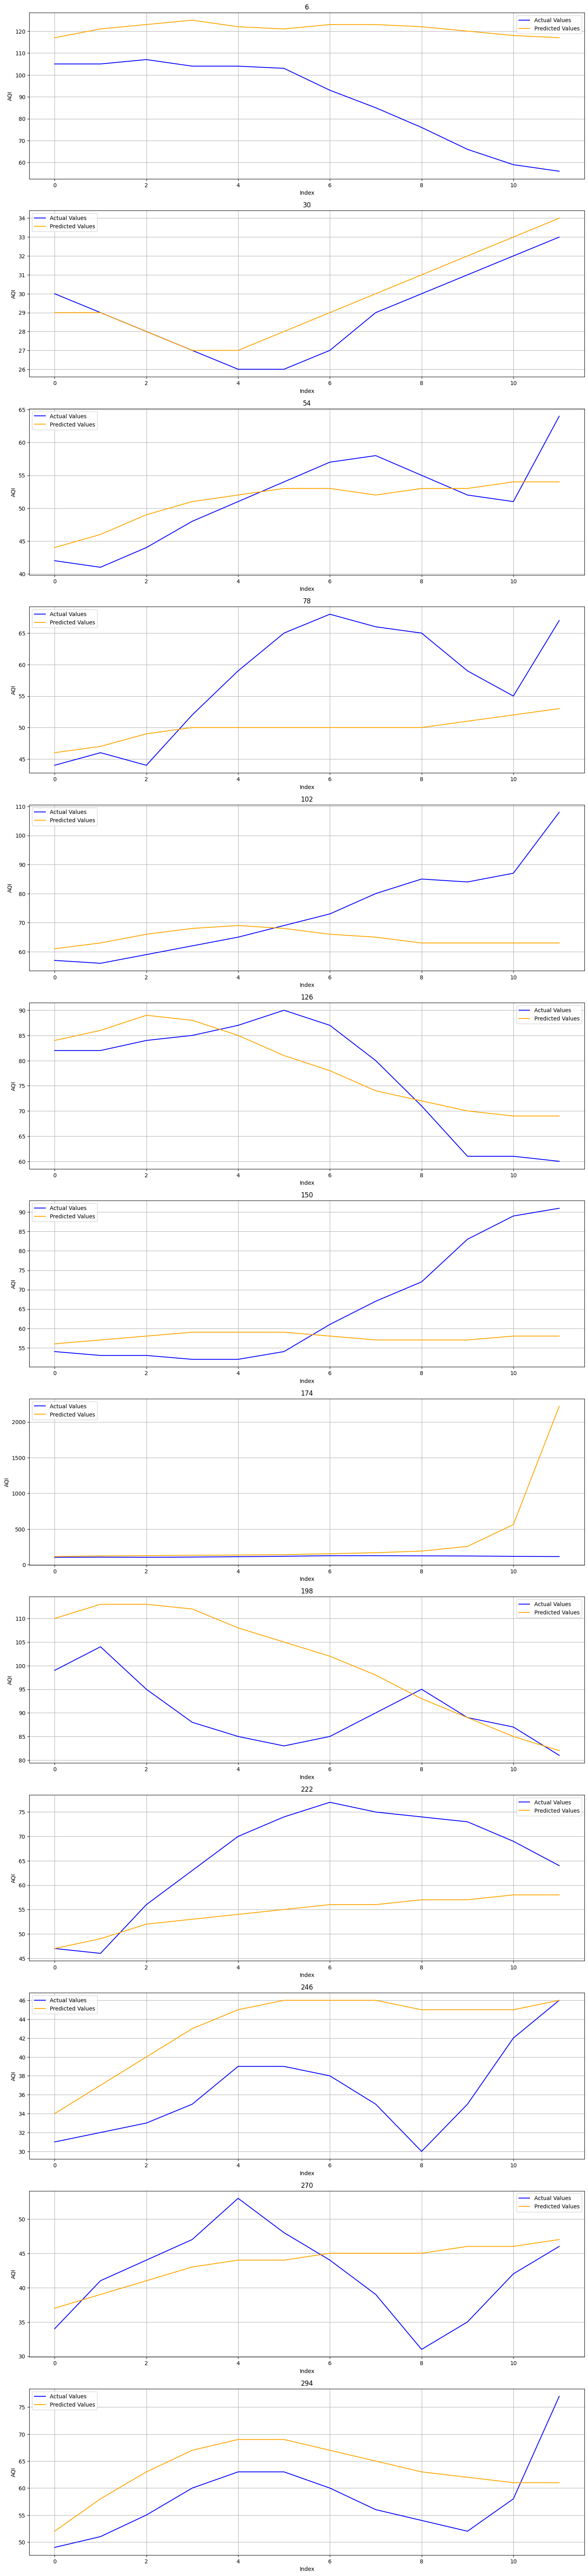

In [13]:
predict_graph(model,y_test)